# Welcome to my kernel 
Skin cancer is the most common human malignancy, is primarily diagnosed visually, beginning with an initial clinical screening and followed potentially by dermoscopic analysis, a biopsy and histopathological examination. Automated classification of skin lesions using images is a challenging task owing to the fine-grained variability in the appearance of skin lesions.

This the **HAM10000 ("Human Against Machine with 10000 training images")** dataset.It consists of 10015 dermatoscopicimages which are released as a training set for academic machine learning purposes and are publiclyavailable through the ISIC archive. This benchmark dataset can be used for machine learning and for comparisons with human experts. 

It has 7 different classes of skin cancer which are listed below :<br>
**1. Melanocytic nevi <br>**
**2. Melanoma <br>**
**3. Benign keratosis-like lesions <br>**
**4. Basal cell carcinoma <br>**
**5. Actinic keratoses <br>**
**6. Vascular lesions <br>**
**7. Dermatofibroma<br>**

In this kernel I will try to detect 7 different classes of skin cancer using Convolution Neural Network with keras tensorflow in backend and then analyse the result to see how the model can be useful in practical scenario.<br>
We will move step by step process to classify 7 classes of cancer.

In this kernel I have followed following 14 steps for model building and evaluation which are as follows : <br>
**Step 1 : Importing Essential Libraries**<br>
**Step 2: Making Dictionary of images and labels** <br>
**Step 3: Reading and Processing Data** <br>
**Step 4: Data Cleaning** <br>
**Step 5: Exploratory data analysis (EDA)** <br>
**Step 6: Loading & Resizing of images **<br>
**Step 7: Train Test Split**<br>
**Step 8: Normalization**<br>
**Step 9: Label Encoding** <br>
**Step 10: Train validation split** <br>
**Step 11: Model Building (CNN)** <br>
**Step 12: Setting Optimizer & Annealing** <br>
**Step 13: Fitting the model**<br>
**Step 14: Model Evaluation (Testing and validation accuracy, confusion matrix, analysis of misclassified instances)** <br>

<img src="https://image.ibb.co/n8PBkL/cover.png">

# Step 1 : importing Essential Libraries

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
import itertools



# --- Configuração de Seeds para Reprodutibilidade ---
np.random.seed(123) 

# --- Importações do Sklearn ---
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# --- Importações do Keras (via TensorFlow 2.x) ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical # Caminho CORRETO para to_categorical

# Importação de Camadas (Layers)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization # Caminho CORRETO para BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Importações de outros módulos
from tensorflow.keras import backend as K

In [16]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()


# Step 2 : Making Dictionary of images and labels
In this step I have made the image path dictionary by joining the folder path from base directory base_skin_dir and merge the images in jpg format from both the folders HAM10000_images_part1.zip and HAM10000_images_part2.zip

In [17]:
import os
from glob import glob

# 1. Defina o DIRETÓRIO RAIZ (corrigido com o 'r')
BASE_DIR = 'C:/Users/ThiagoMoraesRizzieri/Desktop/Cancer_pele' 

# 2. Tenta encontrar arquivos JPG em QUALQUER subpasta (part_1 ou part_2)
# '*/*' significa: procura em QUALQUER subpasta
test_paths = glob(os.path.join(BASE_DIR, '*', '*.jpg'))

print(f"Número de arquivos JPG encontrados: {len(test_paths)}")
print(f"Exemplo de caminho encontrado: {test_paths[0] if test_paths else 'NENHUM ARQUIVO ENCONTRADO'}")

Número de arquivos JPG encontrados: 10015
Exemplo de caminho encontrado: C:/Users/ThiagoMoraesRizzieri/Desktop/Cancer_pele\HAM10000_images_part_1\ISIC_0024306.jpg


In [18]:
# Substitua todas as barras invertidas por barras normais
base_skin_dir = 'C:/Users/ThiagoMoraesRizzieri/Desktop/Cancer_pele'  # Adapte este caminho para o local EXATO onde os arquivos .jpg estão no seu PC"

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Step 3 : Reading & Processing data

In this step we have read the csv by joining the path of image folder which is the base folder where all the images are placed named base_skin_dir.
After that we made some new columns which is easily understood for later reference such as we have made column path which contains the image_id, cell_type which contains the short name of lesion type and at last we have made the categorical column cell_type_idx in which we have categorize the lesion type in to codes from 0 to 6

In [19]:


skin_df = pd.read_csv('HAM10000_metadata.csv')

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


In [20]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:/Users/ThiagoMoraesRizzieri/Desktop/Cancer_p...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:/Users/ThiagoMoraesRizzieri/Desktop/Cancer_p...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:/Users/ThiagoMoraesRizzieri/Desktop/Cancer_p...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:/Users/ThiagoMoraesRizzieri/Desktop/Cancer_p...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:/Users/ThiagoMoraesRizzieri/Desktop/Cancer_p...,Benign keratosis-like lesions,2


# Step 4 : Data Cleaning
In this step we check for Missing values and datatype of each field 

In [21]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

As it is evident from the above that only age has null values which is 57 so we will fill the null values by their mean.

In [22]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

C:\Users\ThiagoMoraesRizzieri\AppData\Local\Temp\ipykernel_8224\3479505362.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)


Now, lets check the presence of null values  again

In [23]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [24]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


# Step 5 : EDA
In this we will explore different features of the dataset , their distrubtions and actual counts

Plot to see distribution of 7 different classes of cell type

<Axes: xlabel='cell_type'>

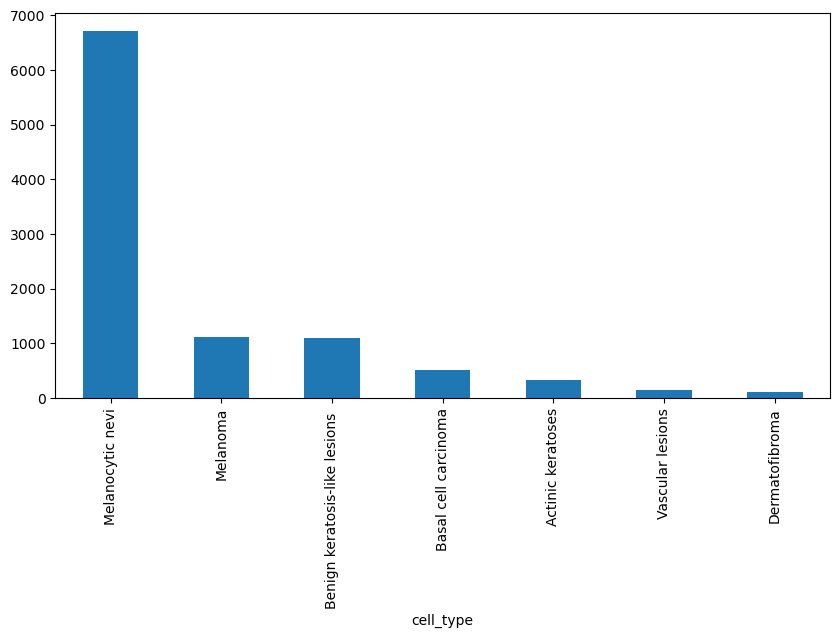

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

Its seems from the above plot that in this dataset cell type Melanecytic nevi has very large number of instances in comparison to other cell types

Plotting of Technical Validation field (ground truth) which is dx_type to see the distribution of its 4 categories which are listed below :<br>
**1. Histopathology(Histo):**  Histopathologic diagnoses of excised lesions have been
performed by specialized dermatopathologists. <br>
**2. Confocal:** Reflectance confocal microscopy is an in-vivo imaging technique with a resolution at near-cellular level , and some facial benign with a grey-world assumption of all training-set images in Lab-color space before
and after  manual histogram changes.<br>
**3. Follow-up:** If nevi monitored by digital dermatoscopy did not show any changes during 3 follow-up visits or 1.5 years biologists  accepted this as evidence of biologic benignity. Only nevi, but no other benign diagnoses were labeled with this type of ground-truth because dermatologists usually do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions. <br>
**4. Consensus:** For typical benign cases without histopathology or followup biologists  provide an expert-consensus rating of authors PT and HK. They applied the consensus label only if both authors independently gave the same unequivocal benign diagnosis. Lesions with this type of groundtruth were usually photographed for educational reasons and did not need
further follow-up or biopsy for confirmation.


<Axes: xlabel='dx_type'>

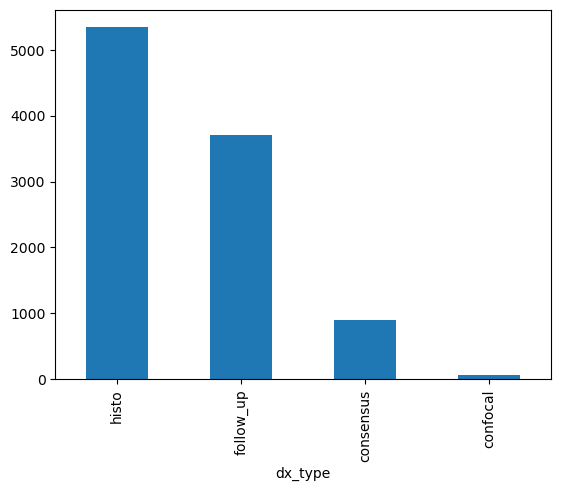

In [26]:
skin_df['dx_type'].value_counts().plot(kind='bar')

Plotting the distribution of localization field 

<Axes: xlabel='localization'>

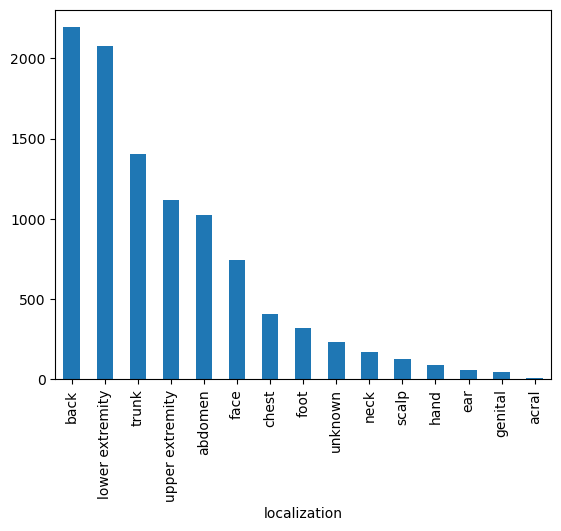

In [27]:
skin_df['localization'].value_counts().plot(kind='bar')

It seems back , lower extremity,trunk and upper extremity are heavily compromised regions of skin cancer 

Now, check the distribution of Age

<Axes: >

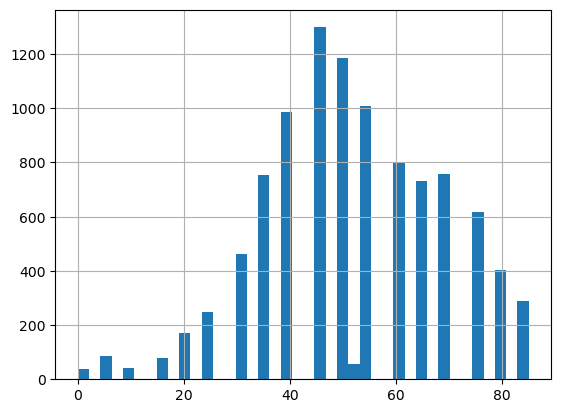

In [28]:
skin_df['age'].hist(bins=40)

It seems that there are larger instances of patients having age from 30 to 60

Lets see the distribution of males and females

<Axes: xlabel='sex'>

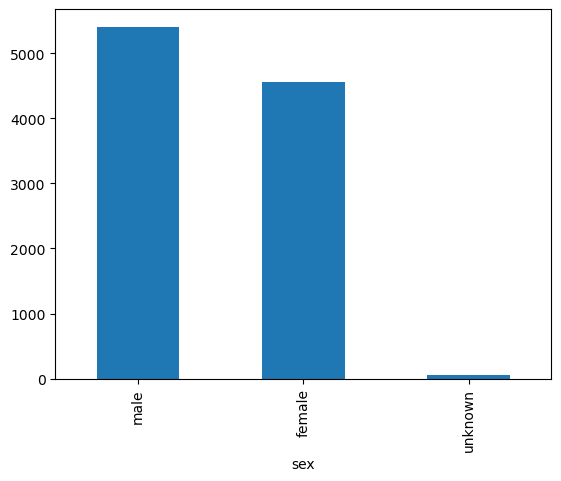

In [29]:

skin_df['sex'].value_counts().plot(kind='bar')

Now lets visualize agewise distribution of skin cancer types

It seems that skin cancer types 0,1, 3 and 5 which are Melanocytic nevi,dermatofibroma,Basal cell carcinoma and Vascular lesions are not much prevalant below the age of 20 years 

Sexwise distribution of skin cancer type

# Step 6: Loading and resizing of images
In this step images will be loaded into the column named image from the image path from the image folder. We also resize the images as the original dimension of images are 450 x 600 x3 which TensorFlow can't handle, so that's why we resize it into 100 x 75. As this step resize all the 10015 images dimensions into 100x 75 so be patient it will take some time.

In [30]:

# Célula Anterior (onde o erro Image.open foi resolvido)
# Garanta que a coluna 'image' seja um array NumPy de tipo UINT8 (0-255)
all_image_paths = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(BASE_DIR, '*_part_*', '*.jpg'))}


# --- 3. Mapear e LIMPAR (Ação CRÍTICA) ---
# Mapeia os caminhos no DataFrame
skin_df['path'] = skin_df['image_id'].map(all_image_paths.get)

# REMOVE TODAS AS LINHAS ONDE O CAMINHO NÃO FOI ENCONTRADO (NaN / None)
# ISSO GARANTE QUE Image.open SÓ RECEBERÁ STRINGS VÁLIDAS.
initial_count = len(skin_df)
skin_df = skin_df.dropna(subset=['path'])
final_count = len(skin_df)

print(f"Limpeza de dados: {initial_count - final_count} linhas removidas onde a imagem não foi encontrada.")


# --- 4. CARREGAR AS IMAGENS (Seu código original, agora seguro) ---
# Agora, o map() só recebe caminhos válidos.
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75)), dtype=np.uint8))

print(f"✅ Imagens carregadas com sucesso! Total: {len(skin_df)}.")

Limpeza de dados: 0 linhas removidas onde a imagem não foi encontrada.
✅ Imagens carregadas com sucesso! Total: 10015.


In [31]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:/Users/ThiagoMoraesRizzieri/Desktop/Cancer_p...,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:/Users/ThiagoMoraesRizzieri/Desktop/Cancer_p...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:/Users/ThiagoMoraesRizzieri/Desktop/Cancer_p...,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:/Users/ThiagoMoraesRizzieri/Desktop/Cancer_p...,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:/Users/ThiagoMoraesRizzieri/Desktop/Cancer_p...,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


**As we can see image column has been added in its color format code** 

Most interesting part its always better to see sample of images
Below we will show images of each cancer type

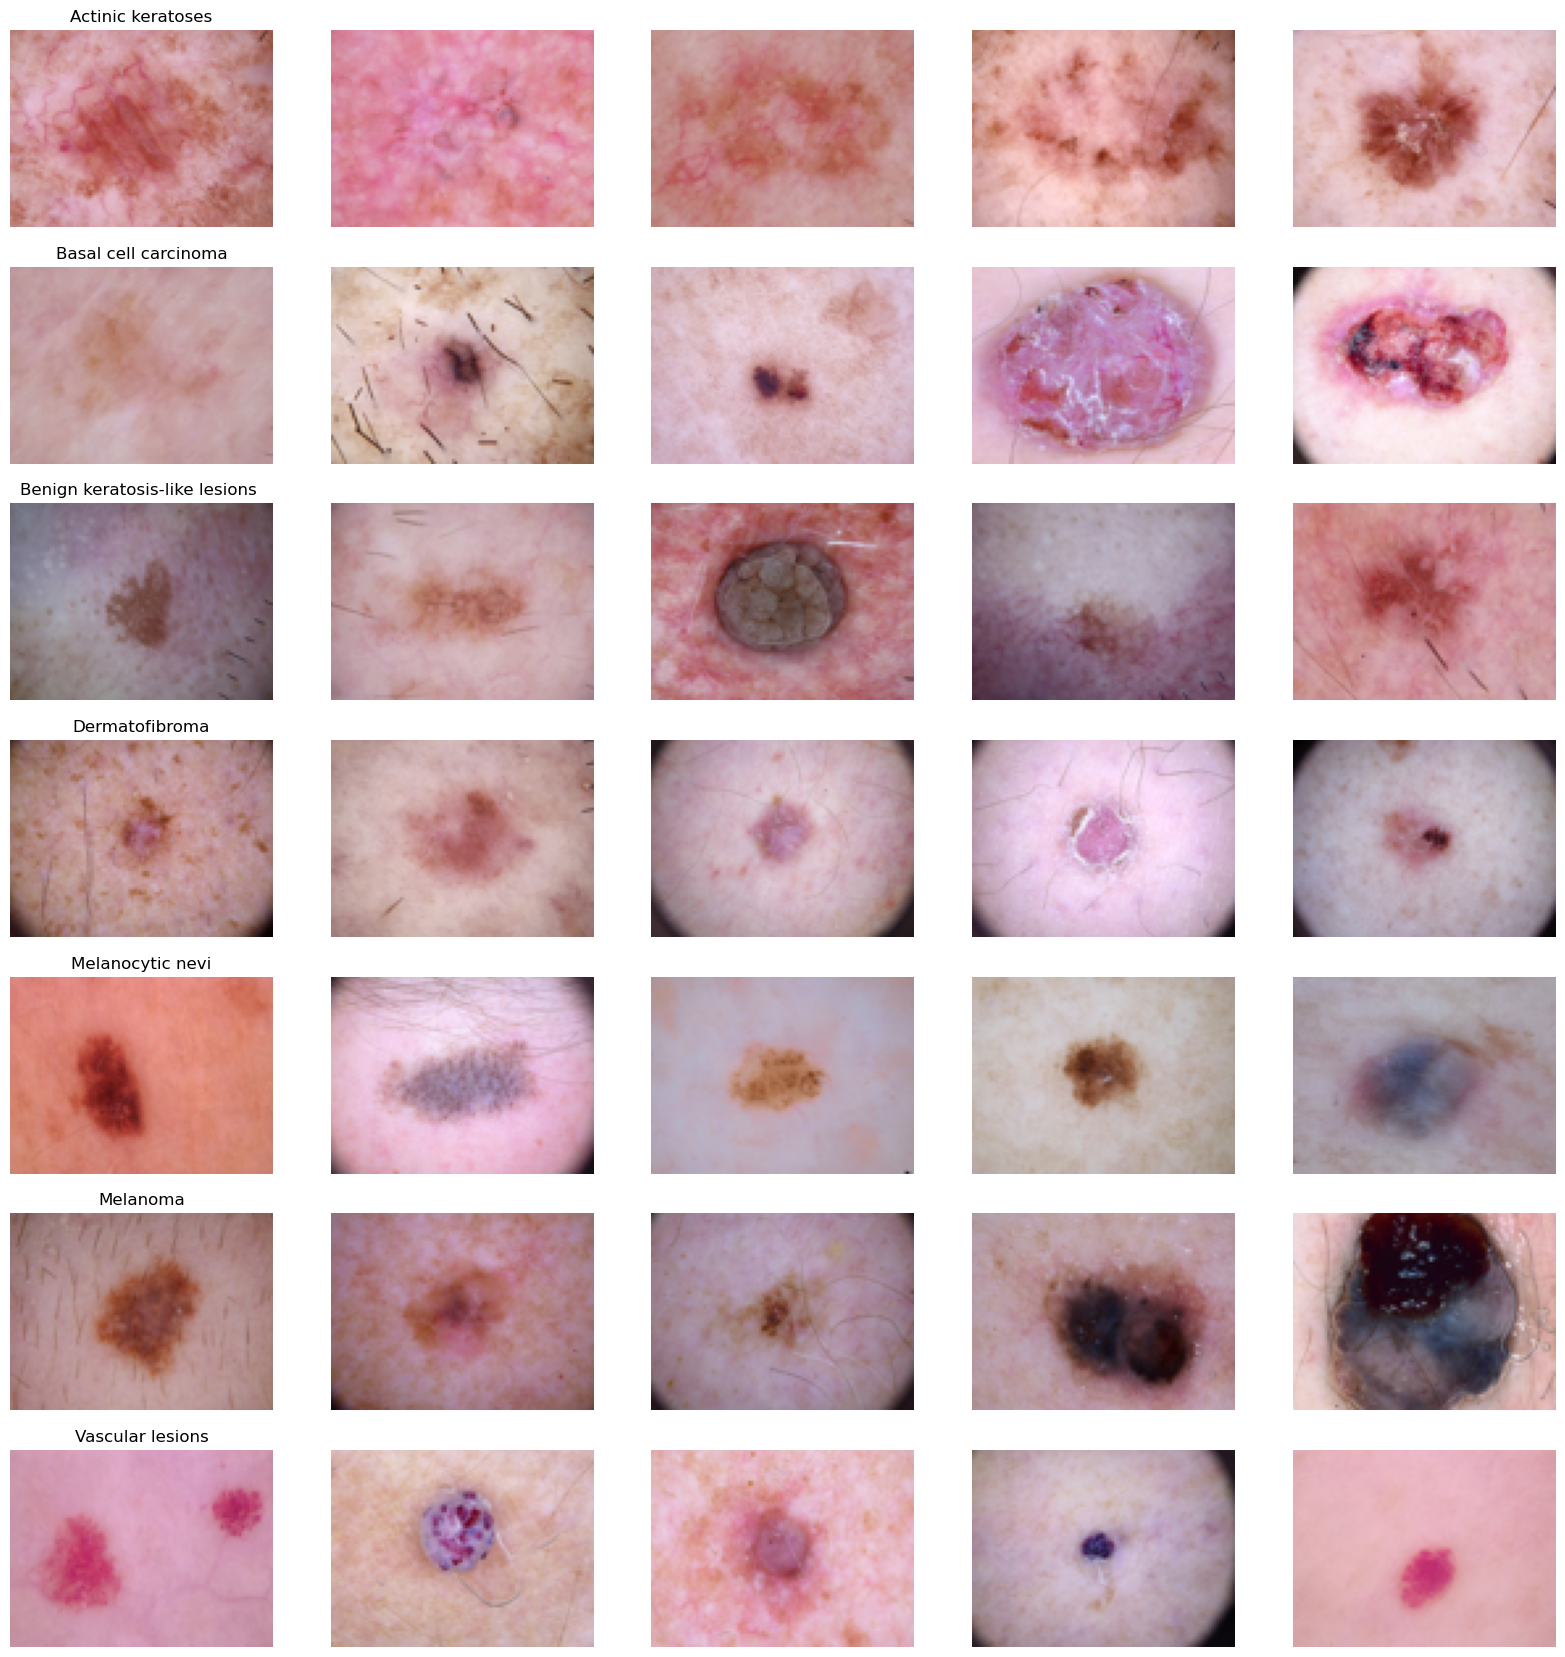

In [32]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [33]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    10015
Name: count, dtype: int64

In [34]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

# Step 7 : Train Test Split
In this step we have splitted the dataset into training and testing set of 80:20 ratio

In [35]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

# Step 8 : Normalization

I choosed to normalize the x_train, x_test by substracting from theor mean values and then dividing by thier standard deviation.

In [36]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Step 9 : Label Encoding
Labels are 7 different classes of skin cancer types from 0 to 6. We need to encode these lables to one hot vectors 

In [37]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

# Step 10 : Splitting training and validation split
I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

In [38]:
# --- Célula de Criação de Arrays (Re-executar após o carregamento da imagem) ---

# 1. Obter a coluna 'image' (x) e a coluna 'dx' (y)
X = np.asarray(skin_df['image'].tolist())
Y = skin_df['dx'] 

# 2. Binarizar (One-Hot Encode) os rótulos para Y (y_validate)
from tensorflow.keras.utils import to_categorical
Y = to_categorical(pd.factorize(Y)[0], num_classes=len(Y.unique()))

# 3. Normalizar X (Dividir por 255)
# Embora suas imagens sejam np.uint8, o modelo CNN espera floats (0-1)
X = X.astype(np.float32) / 255.0

# 4. Separar em Treino e Validação (AGORA COM OS ARRAYS JÁ LIMPOS)
from sklearn.model_selection import train_test_split
x_train, x_validate, y_train, y_validate = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

print(f"Formato de x_validate: {x_validate.shape}")
print(f"Verificando Nulos em x_validate: {np.isnan(x_validate).any()}")
print(f"Verificando Nulos em y_validate: {np.isnan(y_validate).any()}")

Formato de x_validate: (2003, 75, 100, 3)
Verificando Nulos em x_validate: False
Verificando Nulos em y_validate: False


In [39]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

# Step 11: Model Building 
# CNN
I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [40]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

c:\Users\ThiagoMoraesRizzieri\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 100, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 100, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,752,999 (14.32 MB)

 Trainable params: 3,752,999 (14.32 MB)

 Non-trainable params: 0 (0.00 B)

# Step 12: Setting Optimizer and Annealer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.
We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".
The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.
I choosed Adam optimizer because it combines the advantages of two other extensions of stochastic gradient descent. Specifically:

1. Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).

2. Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

Adam realizes the benefits of both AdaGrad and RMSProp.

Adam is a popular algorithm in the field of deep learning because it achieves good results fast.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [41]:
# Define the optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

In [42]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [43]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

# Data Augmentation
It is the optional step. In order to avoid overfitting problem, we need to expand artificially our HAM 10000 dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations 

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [44]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)


For the data augmentation, i choosed to :
Randomly rotate some training images by 10 degrees Randomly Zoom by 10% some training images Randomly shift images horizontally by 10% of the width Randomly shift images vertically by 10% of the height 
Once our model is ready, we fit the training dataset .

# Step 13: Fitting the model
In this step finally I fit the model into x_train, y_train. In this step I have choosen batch size of 10 and 50 epochs   as small as your batch size will be more efficiently your model will train and I have choosen 50 epochs to give the model sufficient epochs to train 

In [ ]:

# # 1. VERIFICAR A COMPILAÇÃO ATUAL
# print("=== DIAGNÓSTICO DO MODELO ===")
# print("Modelo tem otimizador?", hasattr(model, 'optimizer') and model.optimizer is not None)
# print("Loss:", getattr(model, 'loss', 'NÃO DEFINIDA'))
# print("Métricas:", getattr(model, 'metrics_names', 'NÃO DEFINIDAS'))

# # 2. RECOMPILAR O MODELO CORRETAMENTE
# print("\n=== RECOMPILANDO O MODELO ===")
# model.compile(
#     optimizer='adam',  # ou o otimizador que você estava usando
#     loss='categorical_crossentropy',  # para classificação multiclasse
#     # Se for classificação binária, use: loss='binary_crossentropy'
#     metrics=['accuracy']
# )
# print("✓ Modelo recompilado com sucesso!")

# # 3. TESTAR O TREINAMENTO
# print("\n=== TESTANDO TREINAMENTO ===")
# history = model.fit(
#     x_train, y_train,
#     epochs=2,  # apenas teste
#     batch_size=10,
#     validation_data=(x_validate, y_validate),
#     verbose=1
# )
# print("✓ Treinamento funcionou!")

# # 4. SE FUNCIONOU, RODE O TREINAMENTO COMPLETO
# print("\n=== TREINAMENTO COMPLETO ===")
# from tensorflow.keras.callbacks import ReduceLROnPlateau

# # Criar callback limpo
# learning_rate_reduction = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.2,
#     patience=5,
#     min_lr=0.001,
#     verbose=1
# )

# # Treinar com todas as épocas
# history = model.fit(
#     x_train, y_train,
#     epochs=30,
#     batch_size=10,
#     validation_data=(x_validate, y_validate),
#     verbose=1,
#     callbacks=[learning_rate_reduction]
# )



=== DIAGNÓSTICO DO MODELO ===
Modelo tem otimizador? True
Loss: categorical_crossentropy
Métricas: ['loss', 'compile_metrics']

=== RECOMPILANDO O MODELO ===
✓ Modelo recompilado com sucesso!

=== TESTANDO TREINAMENTO ===
Epoch 1/2
802/802 ━━━━━━━━━━━━━━━━━━━━ 79s 95ms/step - accuracy: 0.6684 - loss: 1.0831 - val_accuracy: 0.6695 - val_loss: 0.9485
Epoch 2/2
802/802 ━━━━━━━━━━━━━━━━━━━━ 74s 92ms/step - accuracy: 0.6690 - loss: 0.9724 - val_accuracy: 0.6700 - val_loss: 0.9022
✓ Treinamento funcionou!

=== TREINAMENTO COMPLETO ===
Epoch 1/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 74s 92ms/step - accuracy: 0.6719 - loss: 0.9342 - val_accuracy: 0.6700 - val_loss: 0.9024 - learning_rate: 0.0010
Epoch 2/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 77s 96ms/step - accuracy: 0.6801 - loss: 0.8897 - val_accuracy: 0.6845 - val_loss: 0.8626 - learning_rate: 0.0010
Epoch 3/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 80s 99ms/step - accuracy: 0.6873 - loss: 0.8503 - val_accuracy: 0.6860 - val_loss: 0.8555 - learning_rate: 0.0010
Epo

In [53]:
# SALVAR o modelo completo
model.save('meu_modelo.keras')  # formato .keras (recomendado no Keras 3+)



In [54]:
# Carregar o modelo salvo
modelo_carregado = keras.models.load_model('meu_modelo.keras')

In [55]:
predictions = modelo_carregado.predict(x_validate)
predictions

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


array([[3.48713399e-07, 9.99999166e-01, 3.44580996e-11, ...,
        5.68888415e-13, 6.57279458e-08, 1.03431055e-10],
       [1.48387685e-01, 3.86745743e-02, 1.03457132e-02, ...,
        4.40122746e-03, 6.84318125e-01, 1.04785316e-01],
       [9.14639683e-11, 1.00000000e+00, 7.15010075e-20, ...,
        5.23377692e-21, 3.11418115e-17, 8.90272573e-19],
       ...,
       [1.46191553e-04, 2.93348819e-01, 1.32598032e-16, ...,
        4.07420458e-10, 2.16358442e-09, 6.99771334e-08],
       [1.57691419e-01, 9.82829556e-02, 6.54692203e-02, ...,
        1.77667774e-02, 2.17576921e-01, 2.85905153e-01],
       [1.08003110e-06, 9.99998927e-01, 7.73690573e-12, ...,
        3.11697388e-15, 4.52017937e-11, 4.04180080e-13]],
      shape=(2003, 7), dtype=float32)

In [49]:
predictions = model.predict(x_validate)
predictions

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step


array([[3.48713399e-07, 9.99999166e-01, 3.44580996e-11, ...,
        5.68888415e-13, 6.57279458e-08, 1.03431055e-10],
       [1.48387685e-01, 3.86745743e-02, 1.03457132e-02, ...,
        4.40122746e-03, 6.84318125e-01, 1.04785316e-01],
       [9.14639683e-11, 1.00000000e+00, 7.15010075e-20, ...,
        5.23377692e-21, 3.11418115e-17, 8.90272573e-19],
       ...,
       [1.46191553e-04, 2.93348819e-01, 1.32598032e-16, ...,
        4.07420458e-10, 2.16358442e-09, 6.99771334e-08],
       [1.57691419e-01, 9.82829556e-02, 6.54692203e-02, ...,
        1.77667774e-02, 2.17576921e-01, 2.85905153e-01],
       [1.08003110e-06, 9.99998927e-01, 7.73690573e-12, ...,
        3.11697388e-15, 4.52017937e-11, 4.04180080e-13]],
      shape=(2003, 7), dtype=float32)

In [57]:
# # Versão mais simples - sem gerador
# epochs = 50
# batch_size = 10

# history = model.fit(
#     x_train, y_train,
#     epochs=epochs,
#     batch_size=batch_size,
#     validation_data=(x_validate, y_validate),
#     verbose=1,
#     callbacks=[learning_rate_reduction] if 'learning_rate_reduction' in locals() and learning_rate_reduction is not None else []
# )


# Step 14: Model Evaluation 
In this step we will check the testing accuracy and validation accuracy of our model,plot confusion matrix and also check the missclassified images count of each type

In [58]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.3759 - loss: 97.5857 
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7244 - loss: 1.1176


Validation: accuracy = 0.724413  ;  loss_v = 1.117612
Test: accuracy = 0.375936  ;  loss = 97.585747


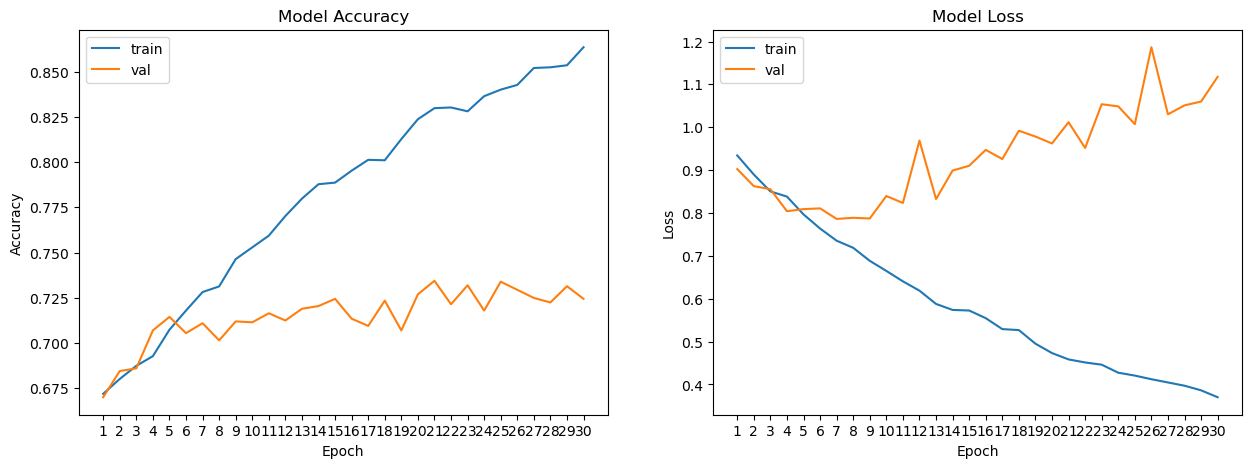

In [61]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # Summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), 
                model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), 
                model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(range(1, len(model_history.history['accuracy']) + 1))
    axs[0].legend(['train', 'val'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), 
                model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), 
                model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(range(1, len(model_history.history['loss']) + 1))
    axs[1].legend(['train', 'val'], loc='best')
    
    plt.show()

# Agora pode usar
plot_model_history(history)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step


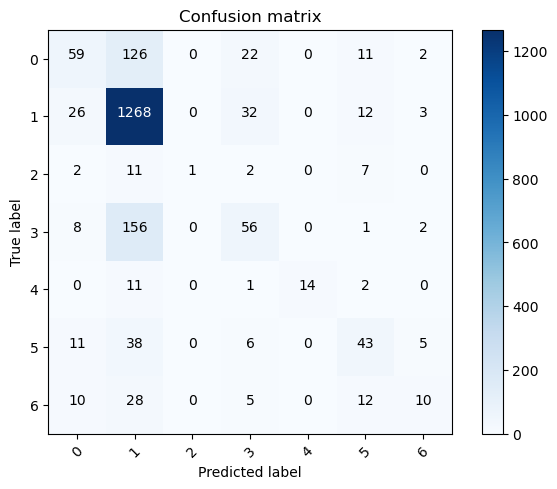

In [62]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Now, lets which category has much incorrect predictions

Text(0, 0.5, 'Fraction classified incorrectly')

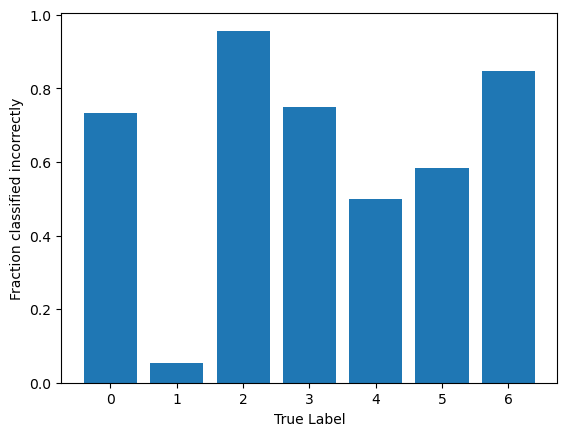

In [63]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

# Conclusion
It seems our model has maximum number of incorrect predictions for Basal cell carcinoma which has code 3, then second most missclassified type is Vascular lesions code 5 then Melanocytic nevi code  0 where as Actinic keratoses code 4 has least misclassified type.

We can also further tune our model to easily achieve the accuracy above 80% and I think still this model is efficient in comparison to detection with human eyes having 77.0344% accuracy 

I hope kagglers like my stepwise approach to classify cancer types. If like then kindly dont forget to hit the **like**


In [ ]:
def classificar_pinta(caminho_imagem, modelo):
    """
    Classifica uma imagem de pinta usando o modelo treinado
    
    Args:
        caminho_imagem: caminho para a imagem (ex: 'minha_pinta.jpg')
        modelo: modelo Keras carregado
    """
    # Carregar a imagem
    img = image.load_img(caminho_imagem, target_size=(75, 100))  # ajustar para o tamanho do seu modelo
    
    # Converter para array numpy
    img_array = image.img_to_array(img)
    
    # Normalizar (mesma normalização usada no treinamento)
    img_array = img_array / 255.0
    
    # Adicionar dimensão do batch (o modelo espera (batch_size, altura, largura, canais))
    img_array = np.expand_dims(img_array, axis=0)
    
    # Fazer a predição
    predictions = modelo.predict(img_array)
    
    # Obter a classe predita
    classe_predita = np.argmax(predictions[0])
    confianca = predictions[0][classe_predita] * 100
    
    # Nomes das classes (ajuste conforme suas classes)
    classes = ['Melanoma', 'Nevo Melanocítico', 'Carcinoma Basocelular', 
               'Queratose Actínica', 'Lesão Benigna', 'Dermatofibroma', 
               'Lesão Vascular']
    
    # Mostrar resultado
    plt.figure(figsize=(10, 5))
    
    # Mostrar a imagem
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Imagem da Pinta')
    plt.axis('off')
    
    # Mostrar as probabilidades
    plt.subplot(1, 2, 2)
    plt.barh(classes, predictions[0] * 100)
    plt.xlabel('Confiança (%)')
    plt.title('Probabilidades por Classe')
    plt.tight_layout()
    plt.show()
    
    # Retornar resultado
    print(f"\n{'='*50}")
    print(f"RESULTADO DA CLASSIFICAÇÃO")
    print(f"{'='*50}")
    print(f"Classe Predita: {classes[classe_predita]}")
    print(f"Confiança: {confianca:.2f}%")
    print(f"{'='*50}\n")
    
    return classe_predita, confianca, predictions[0]

# Usar a função
modelo = keras.models.load_model('melhor_modelo.keras')
classificar_pinta('minha_pinta.jpg', modelo)

# Aplicação Streamlit